# Code to process winter storm information

$\textbf{Introduction}$: The notebook contains code to process the input and output data for the European winter storm severe winds project. Specifically, we introduce a basic nested PC (Principal Components) Regression model with dropouts, and a Variational Encoder-Decoder (VEDs) to predict the quantile function (inversed CDF) of maximum surface wind gusts

The quantile function can be calculated from a given Cumulative Distribution Function (CDF) with the following equation:

$ Q = log_{10} (1 - CDF) $

The quantile function is particularly useful for our project because it accentuates the difference in distribution tail values. This property is useful in our context of predicting probabilities of rare severe winds in winter storms.

## Import relevant packages and data

In [1]:
! pip install optuna

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import optuna
import os
import sys

operating_system = 'mac'

if operating_system == 'win':
    os.chdir('C:/Users/fabau/OneDrive/Documents/GitHub/master-project-cleaned/')
elif operating_system == 'curnagl':
    os.chdir('/work/FAC/FGSE/IDYST/tbeucler/default/fabien/repos/cleaner_version/')
else:
    os.chdir('/Users/fabienaugsburger/Documents/GitHub/master-project-cleaned/')

util_perso = os.path.abspath('util/processing')
sys.path.append(util_perso)
util_perso = os.path.abspath('util/feature_selection')
sys.path.append(util_perso)

from extraction_squares import split_storm_numbers
from selection_vars import prepare_training_data

/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Read the csv files for training time series (inputs)
all_loadings = pd.read_csv('pre_processing/nestedMLR/all_loadings.csv', header=0)

cdf = '_cdf_'
n_vars = 40
selected_var = pd.read_csv(f'pre_processing/feature_selection/selected_vars_loadings/selected_vars_custom{cdf}{n_vars}.csv')['0'].to_list()

# Read the csv files for processed quantile function outputs
output_quantile = pd.read_csv('pre_processing/nestedMLR/log_cdf_max_combined.csv')

# prepare the data

In [15]:
# Extract variable names and storm data
variables = all_loadings['variable']  # First column
storm_data = all_loadings.iloc[:, 1:]  # All columns from the second onward

# Transpose storm data and set variable names as columns
transposed_data = storm_data.T
transposed_data.columns = variables

# Optionally reset index to name storms
transposed_data.index.name = 'storm_number'
transposed_data.reset_index(inplace=True)

# extract the storm number
storm_numbers = transposed_data['storm_number'].copy().to_numpy().astype(int)

updated_columns = []
pca_tracker = {}
# for 20 variables
for var in transposed_data.columns:
    if var not in pca_tracker:
        pca_tracker[var] = 1
    else:
        pca_tracker[var] += 1
    # Append PCA number to the variable name
    updated_columns.append(f"{var}_PCA_{pca_tracker[var]}")
# Update the column names
transposed_data.columns = updated_columns
# rename the first column to storm_number
transposed_data = transposed_data.rename(columns={'storm_number_PCA_1': 'storm_number'})
transposed_data['storm_number'] = transposed_data['storm_number'].astype(int)

# Extract variables most correlated with the target and leaving the storm number
columns_to_select_5 = [col for col in selected_var if col in transposed_data.columns]
transposed_data_5 = transposed_data[columns_to_select_5]

# separate the data in training and testing
storm_index_training, storm_index_test, storm_index_validation = split_storm_numbers(storm_numbers, 0.12, 42, 'number')

# Sort the storm indices
storm_index_training.sort()
storm_index_test.sort()
storm_index_validation.sort()

# add the storm number to the transposed data
transposed_data_5['storm_number'] = storm_numbers
columns_with_storm = transposed_data_5.columns

X_train = prepare_training_data(transposed_data_5, storm_index_training, columns_with_storm)
X_test = prepare_training_data(transposed_data_5, storm_index_test, columns_with_storm)
X_validation = prepare_training_data(transposed_data_5, storm_index_validation, columns_with_storm)

To keep 50 storms in the training set, storms 45 and 87 are removed from the test set.


/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_18981/3925337382.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  transposed_data_5['storm_number'] = storm_numbers


## Check data
Let's do a prelimiary check to familiarize ourselves with the data first. What informations are stored in the csv files?

In [17]:
all_loadings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 894 entries, 0 to 893
Data columns (total 64 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   variable  894 non-null    object 
 1   1         894 non-null    float64
 2   2         894 non-null    float64
 3   3         894 non-null    float64
 4   5         894 non-null    float64
 5   6         894 non-null    float64
 6   7         894 non-null    float64
 7   8         894 non-null    float64
 8   11        894 non-null    float64
 9   12        894 non-null    float64
 10  13        894 non-null    float64
 11  16        894 non-null    float64
 12  19        894 non-null    float64
 13  21        894 non-null    float64
 14  26        894 non-null    float64
 15  27        894 non-null    float64
 16  29        894 non-null    float64
 17  31        894 non-null    float64
 18  32        894 non-null    float64
 19  33        894 non-null    float64
 20  34        894 non-null    float6

The input csv files contain entries of different PC loadings associated with a particular physical variable. In this case, we see 3 different loadings associated with maximum 1000 hPa geopotential heights. Each row entry represents the time series shape characteristics for 1 storm.

In [18]:
output_quantile

,storm_number,storm_name,cluster_0,cluster_1,cluster_2,cluster_3,cluster_4,cluster_5,cluster_6,cluster_7,cluster_8,cluster_9,cluster_10,cluster_11,cluster_12,cluster_13,cluster_14
0,82,C3S_STORM_TRACKS_ERA5,2.242762,1.441315,1.452814,1.705352,1.482131,2.280985,4.591923,1.618292,3.075134,0.556794,1.619725,2.903208,3.807250,0.856282,0.391914
1,1,C3S_STORM_TRACKS_ERA5,2.549915,0.631354,1.490921,3.063364,0.401477,0.314291,3.869775,0.122579,0.081556,0.006147,1.818020,1.396851,1.348957,0.248937,0.762328
2,13,C3S_STORM_TRACKS_ERA5,0.388078,0.111882,2.341128,0.081180,0.461070,0.290018,1.320162,0.097615,0.172890,0.229829,1.615095,2.983414,4.470059,0.174978,0.238000
3,95,AIDEN,0.090794,0.788324,0.375771,2.405377,0.633807,0.136090,3.773348,0.226815,0.507296,0.007835,0.227672,0.907070,0.734044,0.023960,1.022132
4,7,HERTA,1.176497,2.152701,0.839556,4.972494,0.238821,0.338416,2.370679,0.979826,0.835825,0.509907,0.669523,2.056866,1.313424,1.460252,4.788285
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
58,12,C3S_STORM_TRACKS_ERA5,0.644110,0.095139,3.364392,2.349703,0.614161,0.211642,2.991942,0.103584,0.010931,0.295994,1.274047,1.759591,2.270806,0.463708,1.908599
59,73,XAVER,9.164017,1.967819,2.317177,5.309236,2.678723,0.285856,6.795611,0.631347,0.524138,0.308713,1.864410,3.644108,4.920953,0.273122,0.432820
60,8,C3S_STORM_TRACKS_ERA5,2.425189,1.976442,0.632020,2.847837,0.553720,0.094339,6.995991,0.857006,0.069633,0.164015,0.917848,1.430968,0.757042,0.510893,1.421436
61,83,C3S_STORM_TRACKS_ERA5,2.600947,1.348670,0.844972,4.010580,0.809561,0.128716,4.218259,0.902120,0.365990,0.426293,1.721566,1.772529,1.847808,0.122705,2.275047


The output csv files contain entries of quantile functions for 94 storms

## Combine input csvs

In [1]:
'''var1 = input_1000_Z_max.to_numpy()[:,1:]
var3 = input_800_rh_max.to_numpy()[:,1:]
var2 = input_2m_dew_max.to_numpy()[:,1:]'''

# Create and Normalize INPUT_TRAIN
#INPUT_TRAIN = np.concatenate((var1, var2, var3), axis=1)
#scaler = StandardScaler()  # or MinMaxScaler()
#INPUT_TRAIN_NORMALIZED = np.asarray(scaler.fit_transform(INPUT_TRAIN), dtype=np.float32)
# TO DO


In [20]:
# Convert the filtered DataFrame to a NumPy array (if needed, retain specific columns)
INPUT_TRAIN = X_train.to_numpy(dtype=np.float32)
scaler = StandardScaler()  # or MinMaxScaler()
INPUT_TRAIN_NORMALIZED = np.asarray(scaler.fit_transform(INPUT_TRAIN), dtype=np.float32)

# Create ML outputs
filtered_output = output_quantile[output_quantile['storm_number'].isin(storm_index_training)]
filtered_output = filtered_output.drop(columns=['storm_name', 'storm_number'])

# Convert the filtered DataFrame to a NumPy array (if needed, retain specific columns)
OUTPUT_TRAIN = filtered_output.to_numpy(dtype=np.float32)

filtered_input_np = INPUT_TRAIN.T#.to_numpy(dtype=np.float32)
var1 = filtered_input_np[:2, 1:]
var2 = filtered_input_np[2:3, 1:]
var3 = filtered_input_np[3:4, 1:]
brchsize = [0] + [varobj.shape[1] for varobj in [var1,var2,var3]]

In [21]:
brchsize = [0] + [varobj.shape[1] for varobj in [var1,var2,var3]]

In [56]:
# Convert DataFrame to numpy array with transpose:
#  - Rows in this array correspond to original columns of the DataFrame
filtered_input_np = filtered_input.T.to_numpy(dtype=np.float32)

# Build a dictionary where keys are the actual column names, 
# and values are lists of *row indices in the transposed array* 
# that correspond to that column name.
grouped_columns = {}
for i, col_name in enumerate(filtered_input.columns):
    grouped_columns.setdefault(col_name, []).append(i)

# Now compute 'brchsize' for each unique column name:
brchsize = [0]  # start with 0 as in your snippet
for col_name, row_indices in grouped_columns.items():
    # Slice rows in the transposed matrix
    # e.g. taking [:, 1:] if you want to drop the first column as in your code
    var_data = filtered_input_np[row_indices, 1:]
    brchsize.append(var_data.shape[1])

print(brchsize)

[0, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 45, 

## Baseline ML model

In [22]:
# Convert NumPy arrays to PyTorch tensors
x_tensor = torch.tensor(INPUT_TRAIN_NORMALIZED)
y_tensor = torch.tensor(OUTPUT_TRAIN)

# Create a DataLoader
dataset = TensorDataset(x_tensor, y_tensor)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)

In [23]:
class baseline_ts_drop(torch.nn.Module):
    def __init__(self,droprate,brchindices,num_vars):
        super(baseline_ts_drop, self).__init__()
        self.brchindices = brchindices
        self.num_vars = num_vars
        ############################################################
        # Create regression layers dynamically for each input
        ############################################################
        brchsize = self.brchindices[1:]
        self.input_layers = torch.nn.ModuleDict({
            f"input{i+1}": torch.nn.Linear(int(brchsize[i]), 1) for i in range(self.num_vars)
        })
        ############################################################
        # Create dropout layers
        ############################################################
        self.dropout_layers = torch.nn.ModuleDict({
            f"dropout{i+1}": torch.nn.Dropout(droprate) for i in range(self.num_vars)
        })
        self.dropout_end = torch.nn.Dropout(droprate)
        ############################################################
        # Final Dense Layer
        ############################################################
        self.denseout = torch.nn.Linear(self.num_vars,15)

    def forward(self,X):
        brchindex = list(np.asarray(self.brchindices).cumsum())
        ############################################################
        # First regression layer
        ############################################################
        inputs = []
        for i in range(self.num_vars):
            # Extract the relevant branch input
            X_branch = X[:, brchindex[i]:brchindex[i+1]]
            # Apply dropout and linear layer
            X_branch = self.dropout_layers[f"dropout{i+1}"](X_branch)
            input_layer = self.input_layers[f"input{i+1}"](X_branch)

            inputs.append(input_layer)
        ############################################################
        # Concat
        ############################################################
        bestPC = torch.cat(inputs,1)
        ############################################################
        # Prediction layer
        ############################################################
        bestPC = self.dropout_end(bestPC)
        outpred = self.denseout(bestPC)
        return outpred

### Hyperparameter tuning with Optuna

In [24]:
def objective(trial):
  # Model Parameters
  brchindices = brchsize
  numvars = len(brchsize[1:])

  # Initiatlize model
  models,losses = [],[]
  droprate = trial.suggest_float("droprate",0.05,0.45)
  model = baseline_ts_drop(droprate, brchindices, numvars)
  lr = trial.suggest_float("lr",1e-6,1e-3)#,log=True)

  # Training parameters
  optimizer = torch.optim.Adam(model.parameters(),lr=lr)
  criterion = torch.nn.L1Loss()
  n_epochs = trial.suggest_int("n_epochs",500,5000)
  #n_epochs = 500

  scheduler_baselr = trial.suggest_float("base_lr",1e-8,1e-4)
  scheduler_maxlr = trial.suggest_float("max_lr",1e-4,1e-2)
  scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=scheduler_baselr, max_lr=scheduler_maxlr, cycle_momentum=False)

  train_losses = []
  for epoch in range(1,n_epochs+1):
    loss = 0
    for features, labels in dataloader:
      optimizer.zero_grad() # Clears existing gradients from previous epoch
      output = model(features)
      batch_loss = criterion(output, labels)
      batch_loss.backward()
      optimizer.step()
      loss += batch_loss.item()
    scheduler.step()
    loss = loss/len(dataloader)
    train_losses.append(loss)

    #val_loss = ts_models.eval_model(model,
    #                                val_loader,
    #                                criterion,
    #                         l2_lambda)
    #    val_losses.append(val_loss)
    if epoch%100 == 0:
      print('Epoch: {}/{}.............'.format(epoch, n_epochs))
      print("Loss: {:.4f}".format(loss))
    #if val_loss <= min(val_losses):
    #    torch.save(model,'best_model'+str(trial.number))
    #torch.save(model,'./tmp/bayesian/best_model.8.'+str(trial.number)+'.pt')
    return loss


In [25]:
study = optuna.create_study(directions=["minimize"])
study.optimize(objective, n_trials=100)

[I 2024-12-26 18:59:17,783] A new study created in memory with name: no-name-9e950976-2ac6-485e-ab3d-231483e6d338
[W 2024-12-26 18:59:18,328] Trial 0 failed with parameters: {'droprate': 0.3317938717394394, 'lr': 0.000750291841584646, 'n_epochs': 2428, 'base_lr': 8.838029880773306e-05, 'max_lr': 0.0006963222966271213} because of the following error: RuntimeError('mat1 and mat2 shapes cannot be multiplied (10x5 and 49x1)').
Traceback (most recent call last):
  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.9/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "/var/folders/01/5ryz4pnn581dj9gk6r1nn5qr0000gn/T/ipykernel_18981/3204683608.py", line 27, in objective
    output = model(features)
  File "/Users/fabienaugsburger/anaconda3/envs/tensor_flow/lib/python3.9/site-packages/torch/nn/modules/module.py", line 1736, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/Users/fabienaugsburger/

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x5 and 49x1)

In [48]:
# Check the tuned hyperparameters
study.best_params

{'droprate': 0.056681679723688316,
 'lr': 0.0009680581183772895,
 'n_epochs': 4334,
 'base_lr': 6.290614167935168e-05,
 'max_lr': 0.007615186512161224}

### Train model with tuned hyperparameters

In [49]:
def training_loop(model, criterion, optimizer, scheduler, train_loader, epoch):
  train_losses = []
  for epoch in range(epoch):
    model.train()
    training_loss = 0
    for batch_idx, (inputs, targets) in enumerate(train_loader):
      # Forward pass
      predictions = model(inputs)
      loss = criterion(predictions, targets)
      # Zero out existing gradients
      optimizer.zero_grad()
      # Backward pass
      loss.backward()
      optimizer.step()
      training_loss += loss.item()
    # Adjust learning rates after every epoch
    scheduler.step()
    # Check overall training loss
    training_loss = training_loss/len(train_loader)
    train_losses.append(training_loss)
    # Print training loss
    if epoch % 100 == 0:
      print(training_loss)
  return model, train_losses

In [50]:
# Parameter setup
droprate = study.best_params['droprate']
brchindices = brchsize
numvars = len(brchsize[1:])
# Initialize model
model = baseline_ts_drop(droprate, brchindices, numvars)
# Define a loss function and optimizer
loss_fn = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=study.best_params['lr'])
# Use cyclical LR scheduler
scheduler = torch.optim.lr_scheduler.CyclicLR(optimizer, base_lr=study.best_params['base_lr'], max_lr=study.best_params['max_lr'], cycle_momentum=False)

In [51]:
model, train_loss = training_loop(model,loss_fn,optimizer,scheduler,dataloader,study.best_params['n_epochs'])

1.6265590906143188
1.470196533203125
1.1311089038848876
0.8458157896995544
0.778405225276947
0.7046789765357971
0.6653524756431579
0.6913981795310974
0.7012088179588318
0.6256799280643464
0.6464447855949402
0.6128641366958618
0.6636952519416809
0.6607899367809296
0.6205216646194458
0.6555574297904968
0.6927797675132752
0.6128554582595825
0.6833025813102722
0.6570084929466248
0.6367743134498596
0.676402747631073
0.6970734059810638
0.6297924160957337
0.7226609706878662
0.6744549930095672
0.6131468534469604
0.6352802515029907
0.6888851881027221
0.6288867115974426
0.6560128331184387
0.6508706927299499
0.5963697016239167
0.6256826639175415
0.6800871133804322
0.6747231960296631
0.6088108777999878
0.6200833320617676
0.6646770358085632
0.6594496250152588
0.6062576532363891
0.6276357173919678
0.6409727334976196
0.6788089394569397


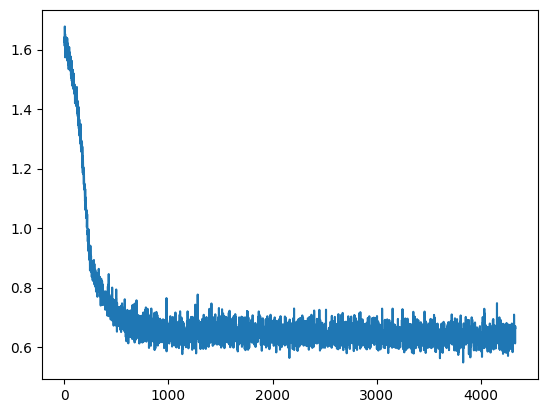

In [52]:
plt.plot(train_loss)
plt.show()